# Predict bike trafic

In [31]:
import datetime

import pandas as pd
import numpy as np

In [32]:
data = pd.read_csv("data_processed.csv", delimiter=";")

## Add features

In [33]:
from astral.geocoder import database, lookup
from astral.sun import sun

city = lookup("Paris", database())

def compute_brightness(date, time):
    date = datetime.date.fromisoformat(date)
    time = datetime.time.fromisoformat(time)
    dt = datetime.datetime.combine(date, time, tzinfo=city.tzinfo)
    sun_data = sun(city.observer, date=date)
    dawn = sun_data["dawn"]
    dusk = sun_data["dusk"]
    if dt < dawn:
        return 0
    if dt > dusk:
        return 0
    else:
        t = (dt - dawn) / (dusk - dawn)
        return np.sin(t * np.pi)

data["brightness"] = data.apply(lambda x: compute_brightness(x["date"], x["time"]), axis=1)

In [34]:
data["nb_years"] = data["date"].apply(lambda x: (datetime.date.fromisoformat(x) - datetime.date(2019,1,1)).days / 365)

In [35]:
# Drop the last 9 rows (missing meteo data)
data = data.dropna()

# Set date and time as index
data = data.set_index(["date", "time"])

In [36]:
data["mean_24h"] = data["compte"].shift(4).rolling(24*4).mean()
data["max_24h"] = data["compte"].shift(4).rolling(24*4).max()
data["min_24h"] = data["compte"].shift(4).rolling(24*4).min()
data["mean_30d"] = data["compte"].shift(4).rolling(30*24*4).mean()
data["max_30d"] = data["compte"].shift(4).rolling(30*24*4).max()
data["min_30d"] = data["compte"].shift(4).rolling(30*24*4).min()
data["24h"] = data["compte"].shift(24*4)
data["7d"] = data["compte"].shift(7*24*4)
data = data.dropna()

## Observe the dataset

In [37]:
data.sample(10)

,,compte,temperature,humidite,cos_date,sin_date,cos_time,sin_time,week_end,vacation,ferie,brightness,nb_years,mean_24h,max_24h,min_24h,mean_30d,max_30d,min_30d,24h,7d
date,time,,,,,,,,,,,,,,,,,,,,
2021-04-15,02:15:00,35.0,276.450000,79.000000,-0.234491,0.972118,0.863836,0.503774,0,0,0,0.000000,2.287671,1269.229167,3758.0,15.0,1191.758681,5102.0,0.0,26.0,20.0
2021-07-09,05:15:00,126.0,289.550000,83.000000,-0.991677,-0.128748,0.254602,0.967046,0,1,0,0.000000,2.520548,2010.854167,5921.0,71.0,1758.477431,7470.0,25.0,119.0,149.0
2020-10-31,11:30:00,836.0,286.683333,83.333333,0.500000,-0.866025,-0.969231,0.246153,1,1,0,0.954369,1.832877,598.010417,1981.0,18.0,1412.646875,7026.0,6.0,901.0,2165.0
2020-05-13,05:15:00,818.0,281.225000,62.250000,-0.666575,0.745438,0.254602,0.967046,0,0,0,0.000000,1.364384,1270.614583,3416.0,27.0,380.311111,3416.0,2.0,883.0,497.0
2021-10-01,22:45:00,770.0,286.300000,91.750000,0.004304,-0.999991,0.874620,-0.484810,0,0,0,0.000000,2.750685,1550.541667,5270.0,80.0,1887.543403,8481.0,14.0,1469.0,1401.0
2021-07-01,06:45:00,602.0,289.125000,82.250000,-0.999963,0.008607,-0.017452,0.999848,0,0,0,0.283678,2.498630,1640.552083,4758.0,85.0,1777.698611,7478.0,21.0,455.0,622.0
2019-10-23,16:00:00,1443.0,287.250000,90.666667,0.373720,-0.927542,-0.500000,-0.866025,0,1,0,0.788344,0.808219,663.114583,2218.0,7.0,606.053819,2936.0,7.0,1507.0,989.0
2020-08-03,02:00:00,48.0,288.516667,65.000000,-0.843776,-0.536696,0.866025,0.500000,0,1,0,0.000000,1.589041,1028.708333,2372.0,65.0,1662.575000,7465.0,32.0,179.0,62.0
2020-09-25,20:00:00,1053.0,284.250000,68.000000,-0.094279,-0.995546,0.500000,-0.866025,0,0,0,0.053088,1.734247,1455.000000,4318.0,45.0,1983.823264,9276.0,34.0,1086.0,1650.0


In [38]:
data.describe()

,compte,temperature,humidite,cos_date,sin_date,cos_time,sin_time,week_end,vacation,ferie,brightness,nb_years,mean_24h,max_24h,min_24h,mean_30d,max_30d,min_30d,24h,7d
count,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,1.022150e+05,1.022150e+05,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000,102215.000000
mean,1035.357834,286.194993,72.792396,-0.028013,-0.007290,-2.289845e-04,5.599003e-05,0.285438,0.352923,0.030054,0.359320,1.541487,1034.991258,3300.909035,35.406750,1027.341151,5184.398748,11.331595,1034.857604,1033.731311
std,1149.358403,6.984378,18.084803,0.697927,0.715590,7.070436e-01,7.071768e-01,0.451625,0.477881,0.170738,0.391278,0.843238,576.294679,1973.572705,35.183729,491.940531,2302.001302,10.786940,1149.458478,1149.781224
min,0.000000,267.650000,15.000000,-1.000000,-0.999991,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.082192,85.895833,179.000000,0.000000,215.250347,907.000000,0.000000,0.000000,0.000000
25%,182.000000,281.104167,59.833333,-0.720667,-0.722117,-7.071068e-01,-7.071068e-01,0.000000,0.000000,0.000000,0.000000,0.810959,524.796875,1674.000000,11.000000,526.872569,2913.000000,3.000000,182.000000,181.000000
50%,623.000000,285.616667,76.333333,-0.047321,-0.043022,-1.836970e-16,1.224647e-16,0.000000,0.000000,0.000000,0.177720,1.542466,1003.000000,3040.000000,22.000000,1034.764931,5381.000000,7.000000,622.000000,619.000000
75%,1535.000000,291.050000,88.000000,0.653680,0.722117,7.071068e-01,7.071068e-01,1.000000,1.000000,0.000000,0.767813,2.271233,1455.276042,4628.000000,46.000000,1378.525868,7100.000000,16.000000,1534.000000,1533.000000
max,9276.000000,314.550000,100.000000,1.000000,0.999991,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,3.000000,2519.916667,9276.000000,244.000000,1994.535417,9276.000000,36.000000,9276.000000,9276.000000


In [39]:
data.corr()

,compte,temperature,humidite,cos_date,sin_date,cos_time,sin_time,week_end,vacation,ferie,brightness,nb_years,mean_24h,max_24h,min_24h,mean_30d,max_30d,min_30d,24h,7d
compte,1.000000,0.240957,-0.255658,-0.060671,-0.138890,-0.413885,-0.267983,-0.139662,-0.083437,-0.067747,0.371618,0.286018,0.474747,0.486513,0.203875,0.387940,0.375572,0.280217,0.876982,0.903513
temperature,0.240957,1.000000,-0.623832,-0.734774,-0.255786,-0.251798,-0.193365,0.001562,0.251239,-0.000921,0.422974,-0.048602,0.181480,0.113876,0.263262,0.125798,0.041216,0.377693,0.240048,0.215058
humidite,-0.255658,-0.623832,1.000000,0.497599,-0.164216,0.353553,0.316226,0.025134,-0.125135,0.028086,-0.527926,0.156873,-0.031654,-0.010509,-0.012714,0.091739,0.125085,-0.042304,-0.218716,-0.191353
cos_date,-0.060671,-0.734774,0.497599,1.000000,-0.014094,-0.000377,0.000117,-0.000874,-0.180841,-0.035140,-0.182404,0.071666,-0.118817,-0.027546,-0.216178,-0.068321,0.085816,-0.281631,-0.058727,-0.044225
sin_date,-0.138890,-0.255786,-0.164216,-0.014094,1.000000,0.000108,0.000002,0.000393,-0.116262,0.028533,0.035446,-0.253610,-0.278817,-0.270011,-0.311459,-0.361738,-0.376655,-0.502348,-0.140322,-0.148002
cos_time,-0.413885,-0.251798,0.353553,-0.000377,0.000108,1.000000,0.000094,-0.000040,-0.000352,0.000057,-0.870962,-0.000164,0.000213,-0.042229,-0.012465,0.000070,-0.000219,-0.000341,-0.413503,-0.412474
sin_time,-0.267983,-0.193365,0.316226,0.000117,0.000002,0.000094,1.000000,-0.000052,0.000108,-0.000014,-0.265668,0.000132,-0.000344,-0.015985,-0.011478,-0.000422,-0.000562,-0.000286,-0.267958,-0.268470
week_end,-0.139662,0.001562,0.025134,-0.000874,0.000393,-0.000040,-0.000052,1.000000,0.089896,-0.025993,0.000199,-0.003328,-0.157560,-0.301855,0.423167,-0.004556,-0.010086,0.012454,-0.037523,-0.138632
vacation,-0.083437,0.251239,-0.125135,-0.180841,-0.116262,-0.000352,0.000108,0.089896,1.000000,0.100220,0.027631,0.017587,-0.150688,-0.203736,0.072865,0.026281,-0.029850,0.226707,-0.070319,-0.031389
ferie,-0.067747,-0.000921,0.028086,-0.035140,0.028533,0.000057,-0.000014,-0.025993,0.100220,1.000000,0.007233,0.003082,-0.098609,-0.114866,0.013911,-0.025320,-0.037070,-0.034346,-0.035671,-0.014530


In [40]:
import matplotlib.pyplot as plt

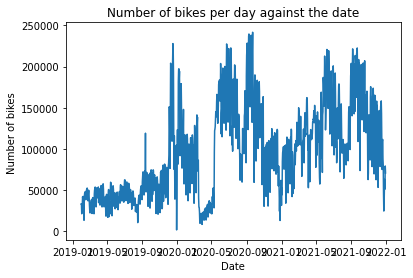

In [41]:
y = data[["compte"]]
y = y.reset_index()
y["date"] = y["date"].apply(datetime.date.fromisoformat)

gb = y.groupby("date")["compte"].sum()

xpoints = gb.index
ypoints = gb

plt.plot(xpoints, ypoints)

plt.xlabel("Date")
plt.ylabel("Number of bikes ")
plt.title("Number of bikes per day against the date")
plt.show()

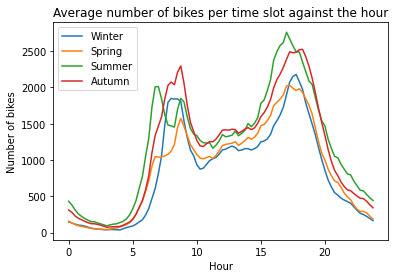

In [42]:
YEAR = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (datetime.date(YEAR,  1,  1),  datetime.date(YEAR,  3, 20))),
           ('spring', (datetime.date(YEAR,  3, 21),  datetime.date(YEAR,  6, 20))),
           ('summer', (datetime.date(YEAR,  6, 21),  datetime.date(YEAR,  9, 22))),
           ('autumn', (datetime.date(YEAR,  9, 23),  datetime.date(YEAR, 12, 20))),
           ('winter', (datetime.date(YEAR, 12, 21),  datetime.date(YEAR, 12, 31)))]

def get_season(now):
    now = now.replace(year=YEAR)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

xpoints = [i/4 for i in range(4*24)]
y["season"] = y["date"].apply(get_season)
y = y.set_index(["date", "time"])

winter = y[y["season"] == "winter"]
spring = y[y["season"] == "spring"]
summer = y[y["season"] == "summer"]
autumn = y[y["season"] == "autumn"]

plt.plot(xpoints, winter["compte"].groupby(level=1).mean(), label="Winter")
plt.plot(xpoints, spring["compte"].groupby(level=1).mean(), label="Spring")
plt.plot(xpoints, summer["compte"].groupby(level=1).mean(), label="Summer")
plt.plot(xpoints, autumn["compte"].groupby(level=1).mean(), label="Autumn")

plt.xlabel("Hour")
plt.ylabel("Number of bikes")
plt.legend()
plt.title("Average number of bikes per time slot against the hour")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


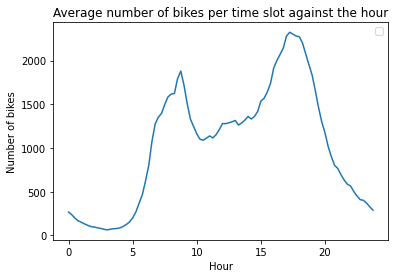

In [43]:
plt.plot(xpoints, y["compte"].groupby(level=1).mean())

plt.xlabel("Hour")
plt.ylabel("Number of bikes")
plt.legend()
plt.title("Average number of bikes per time slot against the hour")
plt.show()

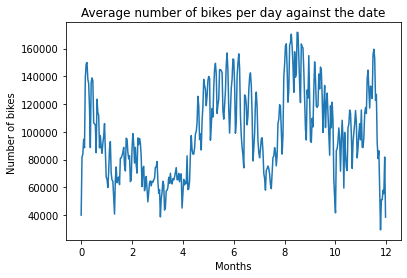

In [44]:
z = y["compte"].groupby(level=0).sum()
z = z.reset_index()
z["date"] = z["date"].apply(lambda x: x.replace(year=YEAR))

xpoints = [i/366*12 for i in range(366)]
gb = z.groupby("date").mean()

plt.plot(xpoints, z.groupby("date").mean())


plt.xlabel("Months")
plt.ylabel("Number of bikes ")
plt.title("Average number of bikes per day against the date")
plt.show()

## Predict bike counts

In [45]:
from sklearn.model_selection import train_test_split

SEED = 42

# Remove data from the first lockdown
data = pd.concat([data.loc[:'2020-03-17'], data.loc['2020-05-11':]])

split = "past_present"

features_to_remove = []

if split == "random":
    y = data[["compte"]]
    X = data[data.columns.difference(pd.Index(["compte", *features_to_remove]))]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

if split == "past_present":
    data_train = data.loc[:"2021-10-01"]
    data_test = data.loc["2021-10-01":]

    y_train = data_train[["compte"]]
    X_train = data_train[data_train.columns.difference(pd.Index(["compte", *features_to_remove]))]
    y_test = data_test[["compte"]]
    X_test = data_test[data_test.columns.difference(pd.Index(["compte", *features_to_remove]))]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (88306, 19)
X_test shape: (8821, 19)


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def eval(y_predict):
    mae = mean_absolute_error(y_predict, y_test)
    mse = mean_squared_error(y_predict, y_test)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {mse ** 0.5:.2f}")

    y = y_test.copy()
    y["predict"] = pd.Series(data = y_predict.reshape(-1), index=y.index)
    res = y.groupby(level=1).apply(lambda x: pd.Series({
        "MAE": mean_absolute_error(x["predict"], x["compte"]),
        "RMSE": mean_squared_error(x["predict"], x["compte"]) ** 0.5,
    }))
    # print(res)

    xpoints = [i/4 for i in range(4*24)]

    plt.plot(xpoints, res["MAE"], label="MAE")
    plt.plot(xpoints, res["RMSE"], label="RMSE")
    plt.plot(xpoints, y_test.groupby(level=1).mean(), label="Average count")


    plt.xlabel("Hour")
    plt.ylabel("Number of bikes")
    plt.title("Metrics against the hour")
    plt.legend()
    plt.show()

MAE: 918.14
RMSE: 1287.30


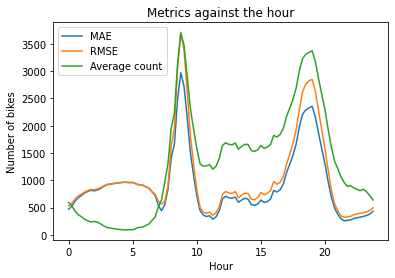

In [47]:
# Compare with a predictor that returns the mean
y_predict = float(y_train.mean()) * np.ones(len(X_test))

eval(y_predict)

MAE: 282.34
RMSE: 476.32


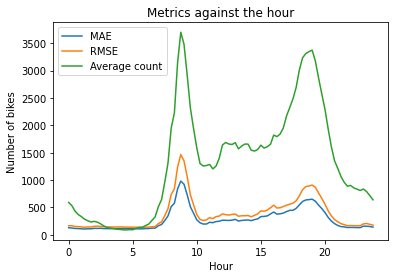

In [48]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)

eval(y_predict)

c:\Users\guill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 235.16
RMSE: 394.28


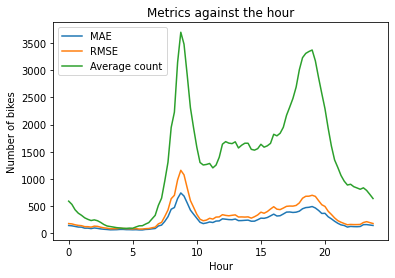

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)

eval(y_predict)

C:\Users\guill\AppData\Local\Temp\ipykernel_50472\3086093355.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


MAE: 211.41
RMSE: 364.50


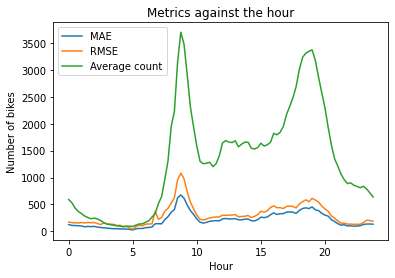

In [50]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)

eval(y_predict)